# Train a SER classifier


## Initializing and importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install the specific tensorflow version.
!pip install tensorflow==2.9.0

In [ ]:
# Check that GPU is connected.
%cd /content/drive/MyDrive/TFG_FER
import tensorflow as tf
tf.test.gpu_device_name()

/content/drive/MyDrive/TFG_FER


'/device:GPU:0'

In [ ]:
# Install other dependencies.
!pip install pydub
!pip install noisereduce

In [ ]:
# Import packages.
import librosa
import noisereduce as nr
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from pydub import AudioSegment, effects
from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras import callbacks
from keras.utils import plot_model
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Attention

In [ ]:
# Check Python and packages' version.
!python3 --version
print("tensorflow: "+tf.__version__)

Python 3.9.16
tensorflow: 2.9.0


## Import datasets

In [ ]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name):
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"


# 'emotions' list fix for classification purposes:
# Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 6 # neutral
    elif e_num == "03": return 3 # happy
    elif e_num == "04": return 4 # sad
    elif e_num == "05": return 0 # angry
    elif e_num == "06": return 2 # fear
    elif e_num == "07": return 1 # disgust
    elif e_num == "08": return 5 # suprise

In [ ]:
# Load RAVDESS dataset.
import zipfile

# Import, unzip and arrange folder with dataset.
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/TFG_SER/Datasets_and_packages/RAVDESS.zip', 'r')
zip_ref.extractall('/content') # Extracts de files into /content.

In [ ]:
# Load TESS dataset.
import zipfile

# Import, unzip and arrange folder with dataset.
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/TFG_SER/Datasets_and_packages/TESS.zip', 'r')
zip_ref.extractall('/content') # Extracts de files into /content.
zip_ref.close()

In [ ]:
# Prepare folder with merged datasets
import shutil

source_file_path = "/content/RAVDESS/RAVDESS"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

source_file_path = "/content/TESS/OAF_angry"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

source_file_path = "/content/TESS/YAF_angry"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

source_file_path = "/content/TESS/OAF_disgust"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

source_file_path = "/content/TESS/YAF_disgust"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

source_file_path = "/content/TESS/OAF_fear"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

source_file_path = "/content/TESS/YAF_fear"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

source_file_path = "/content/TESS/OAF_happy"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

source_file_path = "/content/TESS/YAF_happy"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

source_file_path = "/content/TESS/OAF_surprise"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

source_file_path = "/content/TESS/YAF_surprise"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

source_file_path = "/content/TESS/OAF_sad"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

source_file_path = "/content/TESS/YAF_sad"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

source_file_path = "/content/TESS/OAF_neutral"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

source_file_path = "/content/TESS/YAF_neutral"
destination_folder_path = "/content/AudioFiles/"

# Move the file from the source folder to the destination folder.
shutil.move(source_file_path, destination_folder_path)

!rm -r /content/RAVDESS
!rm -r /content/TESS

## Preprocess

### Extract features

In [ ]:
# Maximum samples count for padding purposes.
sample_lengths = []
folder_path = '/content/AudioFiles'

for subdir, dirs, files in os.walk(folder_path):
  for file in files:
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)

    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))

Maximum sample length: 204288


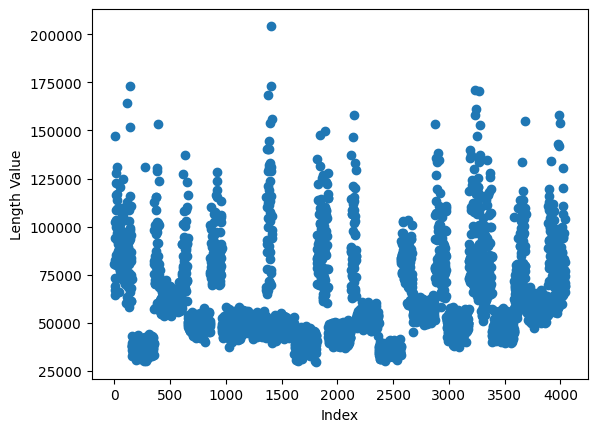

In [ ]:
import matplotlib.pyplot as plt

x_values = range(len(sample_lengths))
y_values = sample_lengths

plt.scatter(x_values, y_values)
plt.xlabel('Index')
plt.ylabel('Length Value')
plt.show()

In [ ]:
for i in range(0, len(sample_lengths)-1):
    if sample_lengths[i] == 204288:
        sample_lengths.pop(i)
print(len(sample_lengths))

4045


In [ ]:
print(max(sample_lengths))

173056


In [ ]:
import time
tic = time.perf_counter()

cont = 1

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 173056 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = '/content/AudioFiles'

for subdir, dirs, files in os.walk(folder_path):
  for file in files:

    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file))
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 0)
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)

      if len(xt) < total_length: # check the length after trimming
          # Pad for duration equalization.
          padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')
      else:
          padded_x = xt[:total_length]
          print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')

      print(cont, padded_x.shape[0])
      cont += 1
    # Noise reduction.
      final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22

   # Features extraction
      f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
      f2 = librosa.feature.zero_crossing_rate(y=final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR
      f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC

   # Emotion extraction from the different databases
      if (find_emotion_T(file) != "-1"): #TESS database validation
            name = find_emotion_T(file)
      else:                              #RAVDESS database validation
            name = file[6:8]

   # Filling the data lists
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotionfix(name))

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

1 173056
2 173056
3 173056
4 173056
5 173056
6 173056
7 173056
8 173056
9 173056
10 173056
11 173056
12 173056
13 173056
14 173056
15 173056
16 173056
17 173056
18 173056
19 173056
20 173056
21 173056
22 173056
23 173056
24 173056
25 173056
26 173056
27 173056
28 173056
29 173056
30 173056
31 173056
32 173056
33 173056
34 173056
35 173056
36 173056
37 173056
38 173056
39 173056
40 173056
41 173056
42 173056
43 173056
44 173056
45 173056
46 173056
47 173056
48 173056
49 173056
50 173056
51 173056
52 173056
53 173056
54 173056
55 173056
56 173056
57 173056
58 173056
59 173056
60 173056
61 173056
62 173056
63 173056
64 173056
65 173056
66 173056
67 173056
68 173056
69 173056
70 173056
71 173056
72 173056
73 173056
74 173056
75 173056
76 173056
77 173056
78 173056
79 173056
80 173056
81 173056
82 173056
83 173056
84 173056
85 173056
86 173056
87 173056
88 173056
89 173056
90 173056
91 173056
92 173056
93 173056
94 173056
95 173056
96 173056
97 173056
98 173056
99 173056
100 173056
101 1730

In [ ]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)
f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (4046, 339, 1)
RMS shape: (4046, 339, 1)
MFCCs shape: (4046, 339, 13)


In [ ]:
# Iterate over the labels and remove any samples with a label of None (label = calm)
indices_to_delete = []
for i, label in enumerate(emotions):
    if label is None:
        indices_to_delete.append(i)

# Remove the rows corresponding to the None labels from each feature array
f_rms = np.delete(f_rms, indices_to_delete, axis=0)
f_zcr = np.delete(f_zcr, indices_to_delete, axis=0)
f_mfccs = np.delete(f_mfccs, indices_to_delete, axis=0)
emotions = np.delete(emotions, indices_to_delete)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)
print('labels:',emotions.shape)

ZCR shape: (4046, 339, 1)
RMS shape: (4046, 339, 1)
MFCCs shape: (4046, 339, 13)
labels: (4046,)


In [ ]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

### Save extracted features

In [ ]:
# Save extracted features individually (just in case).
np.save('/content/drive/MyDrive/TFG_SER/Feature_extraction/f_rms.npy', f_rms)
np.save('/content/drive/MyDrive/TFG_SER/Feature_extraction/f_zcr.npy', f_zcr)
np.save('/content/drive/MyDrive/TFG_SER/Feature_extraction/f_mfccs.npy', f_mfccs)
np.save('/content/drive/MyDrive/TFG_SER/Feature_extraction/emotions.npy', emotions)

In [ ]:
# Save X,Y arrays.
np.save('/content/drive/MyDrive/TFG_SER/Feature_extraction/X.npy', X)
np.save('/content/drive/MyDrive/TFG_SER/Feature_extraction/Y.npy', Y)

### Data split

In [ ]:
# Load the array from the file
X = np.load('/content/drive/MyDrive/TFG_SER/Feature_extraction/X.npy', allow_pickle=True)
Y = np.load('/content/drive/MyDrive/TFG_SER/Feature_extraction/Y.npy', allow_pickle=True)

In [ ]:
# Split to train, validation, and test sets.
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.2, random_state = 1, stratify=Y)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.5, random_state = 1, stratify=y_tosplit)

In [ ]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(3236, 339, 15)
(405, 339, 15)
(405, 339, 15)


In [ ]:
#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 7, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 7, dtype = 'int8')
y_test_class = tf.keras.utils.to_categorical(y_test, 7, dtype = 'int8')

# y_train, y_val, and y_test shape check.
print(np.shape(y_train_class))
print(np.shape(y_val_class))
print(np.shape(y_test_class))

(3236, 7)
(405, 7)
(405, 7)


In [ ]:
# Count the number of samples in each class for the training set
unique_train_labels, train_label_counts = np.unique(y_train, return_counts=True)
print('Training set class counts:')
for label, count in zip(unique_train_labels, train_label_counts):
    print('Class {}: {}'.format(label, count))

Training set class counts:
Class 0: 473
Class 1: 474
Class 2: 474
Class 3: 472
Class 4: 473
Class 5: 473
Class 6: 397


In [ ]:
# Count the number of samples in each class for the validation set
unique_val_labels, val_label_counts = np.unique(y_val, return_counts=True)
print('Validation set class counts:')
for label, count in zip(unique_val_labels, val_label_counts):
    print('Class {}: {}'.format(label, count))

Validation set class counts:
Class 0: 59
Class 1: 59
Class 2: 59
Class 3: 59
Class 4: 59
Class 5: 60
Class 6: 50


In [ ]:
# Count the number of samples in each class for the testing set
unique_test_labels, test_label_counts = np.unique(y_test, return_counts=True)
print('Testing set class counts:')
for label, count in zip(unique_test_labels, test_label_counts):
    print('Class {}: {}'.format(label, count))

Testing set class counts:
Class 0: 60
Class 1: 59
Class 2: 59
Class 3: 59
Class 4: 60
Class 5: 59
Class 6: 49


## Functions

In [ ]:
def plot_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower left')
    ax1.set_ylim([0, 1])

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='lower left')
    ax2.set_ylim([0, max(history.history['loss'])])

    plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Model G

### Build model

In [ ]:
model_H = Sequential()
model_H.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1:3])))
model_H.add(Dropout(0.2))
model_H.add(BatchNormalization())

model_H.add(LSTM(128))
model_H.add(Dropout(0.2))
model_H.add(BatchNormalization())

model_H.add(Dense(64, activation='relu'))
model_H.add(Dropout(0.2))
model_H.add(BatchNormalization())

model_H.add(Dense(7, activation='softmax'))

In [ ]:
print(model_H.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 339, 128)          73728     
                                                                 
 dropout (Dropout)           (None, 339, 128)          0         
                                                                 
 batch_normalization (BatchN  (None, 339, 128)         512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [ ]:
plot_model(model_H, to_file='/content/drive/MyDrive/TFG_SER/LSTM/model_h.png', show_shapes=True, show_layer_names=True)

### Train model G

In [ ]:
# Callbacks functions
checkpoint_path = '/content/drive/MyDrive/TFG_SER/LSTM/model_h.h5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_accuracy',
                           mode='max')
#-> Reduce learning rate after 50 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                    factor=0.1, patience=50)

# Compile & train
model_G.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])
batch_size = 16

history = model_G.fit(x_train, y_train_class,
                      epochs=300, batch_size = batch_size,
                      validation_data = (x_val, y_val_class),
                      callbacks = [mcp_save, rlrop])

# Define the best weights to the model.
model_G.load_weights(checkpoint_path)

Epoch 1/300
203/203 [==============================] - 11s 39ms/step - loss: 2.2906 - accuracy: 0.1845 - val_loss: 1.9103 - val_accuracy: 0.1951 - lr: 0.0010
Epoch 2/300
203/203 [==============================] - 6s 32ms/step - loss: 2.0237 - accuracy: 0.2052 - val_loss: 1.9732 - val_accuracy: 0.1827 - lr: 0.0010
Epoch 3/300
203/203 [==============================] - 6s 31ms/step - loss: 1.9270 - accuracy: 0.2284 - val_loss: 1.8592 - val_accuracy: 0.2395 - lr: 0.0010
Epoch 4/300
203/203 [==============================] - 7s 34ms/step - loss: 1.9119 - accuracy: 0.2197 - val_loss: 1.8967 - val_accuracy: 0.2049 - lr: 0.0010
Epoch 5/300
203/203 [==============================] - 6s 29ms/step - loss: 1.9382 - accuracy: 0.1972 - val_loss: 2.5405 - val_accuracy: 0.1457 - lr: 0.0010
Epoch 6/300
203/203 [==============================] - 6s 31ms/step - loss: 1.9207 - accuracy: 0.2138 - val_loss: 2.0027 - val_accuracy: 0.2395 - lr: 0.0010
Epoch 7/300
203/203 [==============================] - 6s

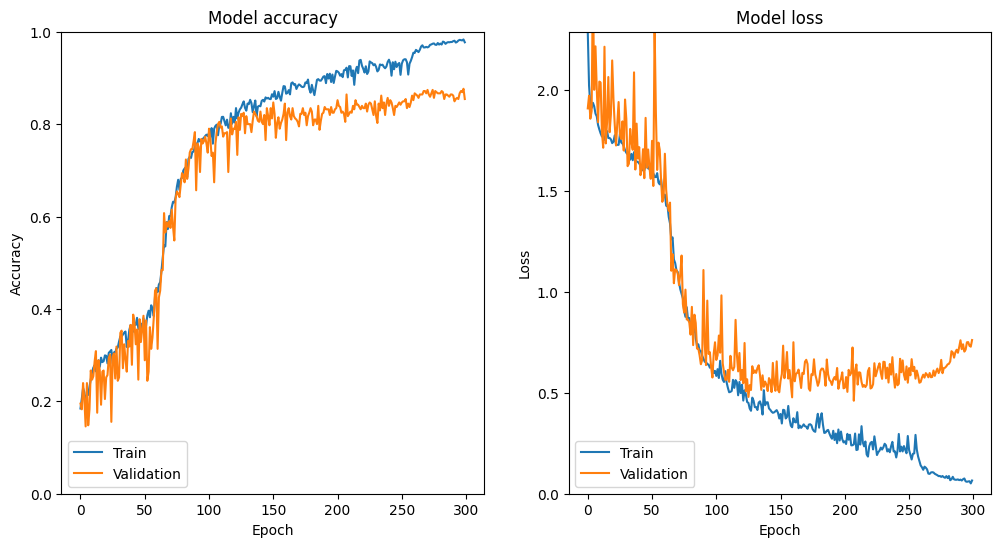

In [ ]:
plot_history(history)

### Evaluation: Validation and test

In [ ]:
model_G = load_model('/content/drive/MyDrive/TFG_SER/LSTM/model_h.h5')

In [ ]:
y_val_pred = model_H.predict(x_val)

13/13 [==============================] - 1s 20ms/step


In [ ]:
y_val_true = np.argmax(y_val_class, axis=1)
y_val_pred = np.argmax(y_val_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(y_val_true, y_val_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        59
           1       0.91      0.86      0.89        59
           2       0.91      0.85      0.88        59
           3       0.83      0.92      0.87        59
           4       0.90      0.80      0.85        59
           5       0.84      0.87      0.85        60
           6       0.85      0.88      0.86        50

    accuracy                           0.88       405
   macro avg       0.88      0.88      0.88       405
weighted avg       0.88      0.88      0.88       405



<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

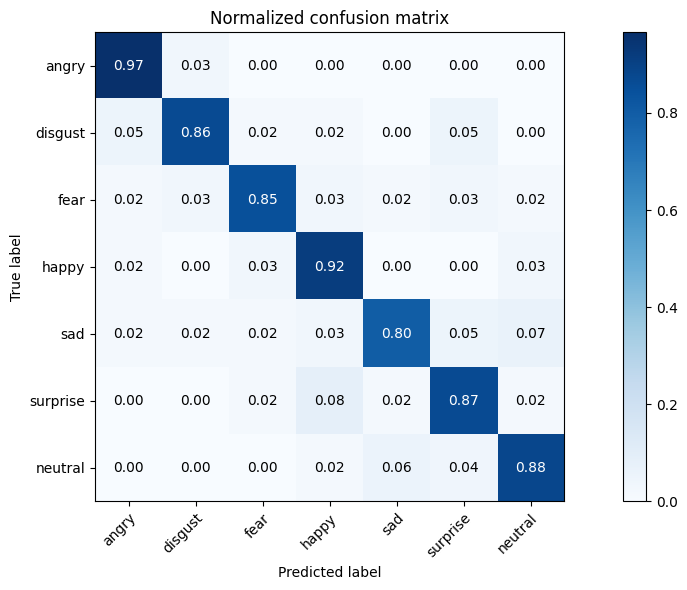

In [ ]:
plot_confusion_matrix(y_val_true, y_val_pred, classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'],
                          normalize=True,
                          title='Normalized confusion matrix')

In [ ]:
loss, acc = model_H.evaluate(x_test, y_test_class)

13/13 [==============================] - 0s 22ms/step - loss: 0.5367 - accuracy: 0.8815


In [ ]:
y_test_pred = model_H.predict(x_test)

13/13 [==============================] - 0s 19ms/step


In [ ]:
y_test_true = np.argmax(y_test_class, axis=1)
y_test_pred = np.argmax(y_test_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86        60
           1       0.93      0.92      0.92        59
           2       0.85      0.93      0.89        59
           3       0.90      0.80      0.85        59
           4       0.85      0.88      0.87        60
           5       0.85      0.85      0.85        59
           6       0.94      0.96      0.95        49

    accuracy                           0.88       405
   macro avg       0.88      0.88      0.88       405
weighted avg       0.88      0.88      0.88       405



<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

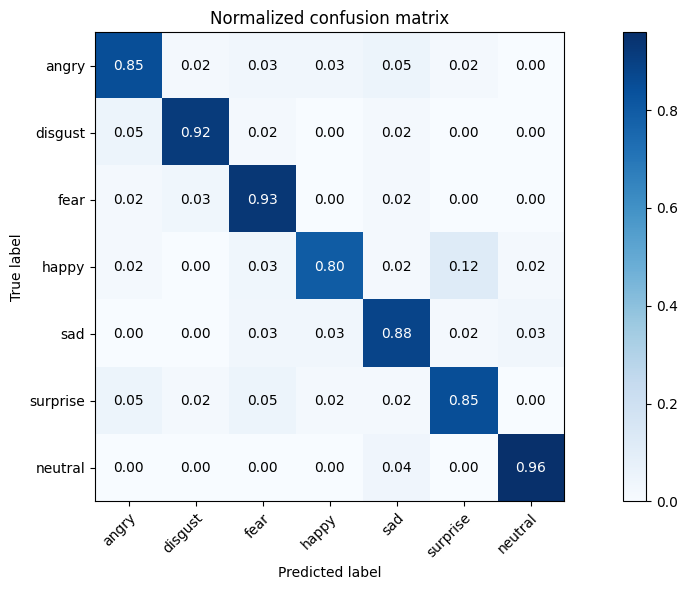

In [ ]:
plot_confusion_matrix(y_test_true, y_test_pred, classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'],
                          normalize=True,
                          title='Normalized confusion matrix')

## Bibliography
https://github.com/MeidanGR/SpeechEmotionRecognition_Realtime